In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

## Credits
### Override from Original Dataset.
Credit : @paddykb
https://www.kaggle.com/competitions/playground-series-s4e1/discussion/469859

Added ~0.0026 to LB score from data leakage. Best LB score without override for this notebook is 0.89347

## Parameters

In [2]:
USE_DATA_LEAK='Y' ## Set to Y to exploit data leak
##
RAND_VAL=42
num_folds=1000 ## Number of folds
n_est=3500 ## Number of estimators

## Read Train and Test Files

In [3]:
df_train = pd.read_csv(r'data\train.csv')
print(df_train.columns)
df_train.head()

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df_test = pd.read_csv(r'data\test.csv')
df_test_ov = df_test.copy()
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


## Scaling

In [5]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

## Feature Engineering

In [6]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    
    return df

In [7]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)
##
feat_cols=df_train.columns.drop(['id','Exited'])
feat_cols=feat_cols.drop(scale_cols)
print(feat_cols)
df_train.head()

Index(['CustomerId', 'Surname', 'Geography', 'Gender', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure', 'AgeCat',
       'Sur_Geo_Gend_Sal'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,AgeCat,Sur_Geo_Gend_Sal
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0,0.202703,0.636,0.000000,0.907279,0,0.0,1.5,2,OkwudilichukwuFranceMale181450.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0,0.202703,0.554,0.000000,0.247483,0,1.0,0.5,2,OkwudiliolisaFranceMale49504.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0,0.297297,0.656,0.000000,0.924364,0,0.0,5.0,2,HsuehFranceMale184867.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0,0.216216,0.462,0.593398,0.422787,0,1.0,2.0,2,KaoFranceMale84561.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,0,0.202703,0.732,0.000000,0.075293,0,1.0,2.5,2,ChiemenamSpainMale15069.0


In [8]:
X=df_train[feat_cols]
y=df_train['Exited']
##
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5, 12, 15, 16], dtype=int64)

## Training

In [9]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.022,
    task_type='GPU',
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8799399	best: 0.8799399 (0)	total: 25.1ms	remaining: 1m 27s
300:	test: 0.8973486	best: 0.8973486 (300)	total: 6.89s	remaining: 1m 13s
600:	test: 0.8989041	best: 0.8989041 (600)	total: 13.9s	remaining: 1m 7s
900:	test: 0.8994743	best: 0.8994743 (880)	total: 21.1s	remaining: 1m 1s
1200:	test: 0.8999081	best: 0.8999081 (1200)	total: 28.2s	remaining: 53.9s
1500:	test: 0.9001486	best: 0.9001486 (1500)	total: 35s	remaining: 46.7s
1800:	test: 0.9003014	best: 0.9003014 (1800)	total: 42s	remaining: 39.6s
2100:	test: 0.9004351	best: 0.9004602 (2055)	total: 49s	remaining: 32.6s
2400:	test: 0.9005135	best: 0.9005148 (2365)	total: 56s	remaining: 25.6s
2700:	test: 0.9005514	best: 0.9005681 (2560)	total: 1m 3s	remaining: 18.7s
3000:	test: 0.9006250	best: 0.9006325 (2995)	total: 1m 10s	remaining: 11.7s
3300:	test: 0.9006976	best: 0.9007387 (3265)	total: 1m 17s	remaining: 4.68s
3499:	test: 0.9007211	best: 0.9007387 (3265)	total: 1m 22s	remaining: 0us
bestTest = 0.9007386863
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8740663	best: 0.8740663 (0)	total: 23.5ms	remaining: 1m 22s
300:	test: 0.8965293	best: 0.8965293 (300)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8983068	best: 0.8983068 (600)	total: 13.8s	remaining: 1m 6s
900:	test: 0.8987129	best: 0.8987223 (870)	total: 20.7s	remaining: 59.8s
1200:	test: 0.8989481	best: 0.8989818 (1185)	total: 27.5s	remaining: 52.6s
1500:	test: 0.8991437	best: 0.8991437 (1500)	total: 34.2s	remaining: 45.6s
1800:	test: 0.8992561	best: 0.8992890 (1750)	total: 41.2s	remaining: 38.9s
2100:	test: 0.8993547	best: 0.8993598 (2060)	total: 48.2s	remaining: 32.1s
2400:	test: 0.8993617	best: 0.8993761 (2200)	total: 55.2s	remaining: 25.3s
2700:	test: 0.8993785	best: 0.8993959 (2675)	total: 1m 2s	remaining: 18.5s
3000:	test: 0.8993899	best: 0.8994249 (2905)	total: 1m 9s	remaining: 11.6s
3300:	test: 0.8992988	best: 0.8994249 (2905)	total: 1m 16s	remaining: 4.62s
3499:	test: 0.8993260	best: 0.8994249 (2905)	total: 1m 21s	remaining: 0us
bestTest = 0.8994249105
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8716685	best: 0.8716685 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8919341	best: 0.8919341 (300)	total: 6.95s	remaining: 1m 13s
600:	test: 0.8939363	best: 0.8939363 (600)	total: 13.7s	remaining: 1m 6s
900:	test: 0.8946908	best: 0.8946908 (900)	total: 20.7s	remaining: 59.7s
1200:	test: 0.8951668	best: 0.8951668 (1200)	total: 27.6s	remaining: 52.8s
1500:	test: 0.8953266	best: 0.8953315 (1435)	total: 34.5s	remaining: 45.9s
1800:	test: 0.8954665	best: 0.8954852 (1780)	total: 41.4s	remaining: 39.1s
2100:	test: 0.8955782	best: 0.8956050 (2000)	total: 48.6s	remaining: 32.3s
2400:	test: 0.8956758	best: 0.8956758 (2400)	total: 55.8s	remaining: 25.5s
2700:	test: 0.8957021	best: 0.8957189 (2525)	total: 1m 3s	remaining: 18.6s
3000:	test: 0.8957612	best: 0.8957615 (2945)	total: 1m 10s	remaining: 11.7s
3300:	test: 0.8957451	best: 0.8957681 (3260)	total: 1m 17s	remaining: 4.67s
3499:	test: 0.8957382	best: 0.8957681 (3260)	total: 1m 22s	remaining: 0us
bestTest = 0.8957681358
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8704261	best: 0.8704261 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.8919497	best: 0.8919497 (300)	total: 7.02s	remaining: 1m 14s
600:	test: 0.8942246	best: 0.8942246 (600)	total: 13.8s	remaining: 1m 6s
900:	test: 0.8949999	best: 0.8949999 (900)	total: 20.7s	remaining: 59.7s
1200:	test: 0.8953457	best: 0.8953457 (1200)	total: 27.6s	remaining: 52.9s
1500:	test: 0.8956937	best: 0.8956962 (1490)	total: 34.6s	remaining: 46s
1800:	test: 0.8958080	best: 0.8958119 (1795)	total: 41.6s	remaining: 39.3s
2100:	test: 0.8957486	best: 0.8958134 (1810)	total: 48.6s	remaining: 32.4s
2400:	test: 0.8958069	best: 0.8958317 (2300)	total: 55.7s	remaining: 25.5s
2700:	test: 0.8958233	best: 0.8958330 (2680)	total: 1m 2s	remaining: 18.6s
3000:	test: 0.8957962	best: 0.8958583 (2935)	total: 1m 9s	remaining: 11.6s
3300:	test: 0.8957019	best: 0.8958583 (2935)	total: 1m 17s	remaining: 4.65s
3499:	test: 0.8956445	best: 0.8958583 (2935)	total: 1m 21s	remaining: 0us
bestTest = 0.895858258
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8730526	best: 0.8730526 (0)	total: 18.8ms	remaining: 1m 5s
300:	test: 0.8945688	best: 0.8945688 (300)	total: 6.88s	remaining: 1m 13s
600:	test: 0.8961658	best: 0.8961658 (600)	total: 13.6s	remaining: 1m 5s
900:	test: 0.8966763	best: 0.8966763 (900)	total: 20.3s	remaining: 58.7s
1200:	test: 0.8969499	best: 0.8969631 (1175)	total: 27.5s	remaining: 52.6s
1500:	test: 0.8971978	best: 0.8972022 (1485)	total: 34.7s	remaining: 46.1s
1800:	test: 0.8972842	best: 0.8973231 (1705)	total: 41.7s	remaining: 39.3s
2100:	test: 0.8973995	best: 0.8974056 (2085)	total: 48.9s	remaining: 32.5s
2400:	test: 0.8974720	best: 0.8974963 (2335)	total: 56.1s	remaining: 25.7s
2700:	test: 0.8975307	best: 0.8975435 (2690)	total: 1m 3s	remaining: 18.7s
3000:	test: 0.8975831	best: 0.8975844 (2760)	total: 1m 10s	remaining: 11.7s
3300:	test: 0.8975615	best: 0.8975844 (2760)	total: 1m 17s	remaining: 4.67s
3499:	test: 0.8975362	best: 0.8975844 (2760)	total: 1m 22s	remaining: 0us
bestTest = 0.8975843787
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8767630	best: 0.8767630 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8984721	best: 0.8984721 (300)	total: 7.03s	remaining: 1m 14s
600:	test: 0.9006996	best: 0.9006996 (600)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9014853	best: 0.9014853 (900)	total: 20.9s	remaining: 1m
1200:	test: 0.9017957	best: 0.9018030 (1165)	total: 27.9s	remaining: 53.3s
1500:	test: 0.9021265	best: 0.9021265 (1500)	total: 34.8s	remaining: 46.3s
1800:	test: 0.9024109	best: 0.9024263 (1790)	total: 41.9s	remaining: 39.5s
2100:	test: 0.9026430	best: 0.9026430 (2100)	total: 48.9s	remaining: 32.6s
2400:	test: 0.9027616	best: 0.9027847 (2345)	total: 56.2s	remaining: 25.7s
2700:	test: 0.9028214	best: 0.9028214 (2700)	total: 1m 3s	remaining: 18.7s
3000:	test: 0.9030168	best: 0.9030168 (3000)	total: 1m 10s	remaining: 11.7s
3300:	test: 0.9030681	best: 0.9030719 (3290)	total: 1m 17s	remaining: 4.67s
3499:	test: 0.9030566	best: 0.9030873 (3365)	total: 1m 22s	remaining: 0us
bestTest = 0.9030872583
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8776058	best: 0.8776058 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.8974738	best: 0.8974738 (300)	total: 6.88s	remaining: 1m 13s
600:	test: 0.8994576	best: 0.8994576 (600)	total: 13.6s	remaining: 1m 5s
900:	test: 0.9000906	best: 0.9000906 (900)	total: 20.4s	remaining: 58.8s
1200:	test: 0.9006199	best: 0.9006199 (1200)	total: 27.2s	remaining: 52.1s
1500:	test: 0.9007956	best: 0.9008090 (1460)	total: 34.3s	remaining: 45.6s
1800:	test: 0.9009714	best: 0.9009714 (1800)	total: 41.3s	remaining: 38.9s
2100:	test: 0.9011130	best: 0.9011147 (2080)	total: 48.3s	remaining: 32.2s
2400:	test: 0.9012972	best: 0.9012972 (2400)	total: 55.4s	remaining: 25.4s
2700:	test: 0.9013665	best: 0.9013714 (2680)	total: 1m 2s	remaining: 18.5s
3000:	test: 0.9014463	best: 0.9014654 (2980)	total: 1m 9s	remaining: 11.6s
3300:	test: 0.9014823	best: 0.9014823 (3300)	total: 1m 17s	remaining: 4.65s
3499:	test: 0.9014669	best: 0.9014879 (3335)	total: 1m 21s	remaining: 0us
bestTest = 0.9014878869
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8700530	best: 0.8700530 (0)	total: 21.2ms	remaining: 1m 14s
300:	test: 0.8889169	best: 0.8889169 (300)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8904647	best: 0.8904647 (600)	total: 13.8s	remaining: 1m 6s
900:	test: 0.8911433	best: 0.8911461 (895)	total: 20.6s	remaining: 59.6s
1200:	test: 0.8915205	best: 0.8915205 (1200)	total: 27.6s	remaining: 52.7s
1500:	test: 0.8917575	best: 0.8917575 (1500)	total: 34.4s	remaining: 45.8s
1800:	test: 0.8919445	best: 0.8919445 (1800)	total: 41.5s	remaining: 39.1s
2100:	test: 0.8921072	best: 0.8921115 (2070)	total: 48.5s	remaining: 32.3s
2400:	test: 0.8921877	best: 0.8921877 (2400)	total: 55.5s	remaining: 25.4s
2700:	test: 0.8922671	best: 0.8922807 (2655)	total: 1m 2s	remaining: 18.5s
3000:	test: 0.8922720	best: 0.8922928 (2755)	total: 1m 9s	remaining: 11.6s
3300:	test: 0.8923007	best: 0.8923123 (3285)	total: 1m 17s	remaining: 4.64s
3499:	test: 0.8922969	best: 0.8923180 (3330)	total: 1m 21s	remaining: 0us
bestTest = 0.8923180401
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8644133	best: 0.8644133 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.8867047	best: 0.8867047 (300)	total: 6.96s	remaining: 1m 14s
600:	test: 0.8890718	best: 0.8890718 (600)	total: 13.7s	remaining: 1m 6s
900:	test: 0.8900500	best: 0.8900500 (900)	total: 20.7s	remaining: 59.7s
1200:	test: 0.8904684	best: 0.8904704 (1195)	total: 27.8s	remaining: 53.2s
1500:	test: 0.8906569	best: 0.8906569 (1500)	total: 34.9s	remaining: 46.5s
1800:	test: 0.8908592	best: 0.8908781 (1790)	total: 42.2s	remaining: 39.8s
2100:	test: 0.8910168	best: 0.8910168 (2100)	total: 49.3s	remaining: 32.8s
2400:	test: 0.8910760	best: 0.8910930 (2180)	total: 56.5s	remaining: 25.8s
2700:	test: 0.8912327	best: 0.8912467 (2665)	total: 1m 3s	remaining: 18.8s
3000:	test: 0.8912982	best: 0.8913105 (2985)	total: 1m 10s	remaining: 11.8s
3300:	test: 0.8913227	best: 0.8913352 (3090)	total: 1m 18s	remaining: 4.7s
3499:	test: 0.8913034	best: 0.8913514 (3345)	total: 1m 22s	remaining: 0us
bestTest = 0.8913514018
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8747750	best: 0.8747750 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.8961183	best: 0.8961183 (300)	total: 6.9s	remaining: 1m 13s
600:	test: 0.8983674	best: 0.8983674 (600)	total: 13.9s	remaining: 1m 6s
900:	test: 0.8989767	best: 0.8989767 (900)	total: 20.8s	remaining: 60s
1200:	test: 0.8992445	best: 0.8992445 (1200)	total: 27.7s	remaining: 52.9s
1500:	test: 0.8994455	best: 0.8994505 (1495)	total: 34.4s	remaining: 45.8s
1800:	test: 0.8995866	best: 0.8996025 (1790)	total: 41.3s	remaining: 39s
2100:	test: 0.8997355	best: 0.8997392 (2090)	total: 48.2s	remaining: 32.1s
2400:	test: 0.8997334	best: 0.8997617 (2350)	total: 55.2s	remaining: 25.3s
2700:	test: 0.8997877	best: 0.8997918 (2660)	total: 1m 2s	remaining: 18.4s
3000:	test: 0.8997878	best: 0.8997926 (2980)	total: 1m 9s	remaining: 11.5s
3300:	test: 0.8997284	best: 0.8998018 (3010)	total: 1m 16s	remaining: 4.6s
3499:	test: 0.8996971	best: 0.8998018 (3010)	total: 1m 20s	remaining: 0us
bestTest = 0.8998017907
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8792405	best: 0.8792405 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.8999943	best: 0.8999943 (300)	total: 6.84s	remaining: 1m 12s
600:	test: 0.9020156	best: 0.9020156 (600)	total: 13.6s	remaining: 1m 5s
900:	test: 0.9027283	best: 0.9027283 (900)	total: 20.4s	remaining: 59s
1200:	test: 0.9031026	best: 0.9031079 (1195)	total: 27.4s	remaining: 52.4s
1500:	test: 0.9033760	best: 0.9033760 (1500)	total: 34.4s	remaining: 45.9s
1800:	test: 0.9035596	best: 0.9035624 (1770)	total: 41.5s	remaining: 39.1s
2100:	test: 0.9037082	best: 0.9037082 (2100)	total: 48.5s	remaining: 32.3s
2400:	test: 0.9039509	best: 0.9039509 (2400)	total: 55.7s	remaining: 25.5s
2700:	test: 0.9040737	best: 0.9040931 (2685)	total: 1m 2s	remaining: 18.6s
3000:	test: 0.9041180	best: 0.9041191 (2995)	total: 1m 10s	remaining: 11.7s
3300:	test: 0.9042045	best: 0.9042085 (3290)	total: 1m 17s	remaining: 4.66s
3499:	test: 0.9042293	best: 0.9042293 (3499)	total: 1m 22s	remaining: 0us
bestTest = 0.9042292833
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8754671	best: 0.8754671 (0)	total: 34.9ms	remaining: 2m 2s
300:	test: 0.8992103	best: 0.8992103 (300)	total: 7s	remaining: 1m 14s
600:	test: 0.9016173	best: 0.9016178 (590)	total: 13.8s	remaining: 1m 6s
900:	test: 0.9023316	best: 0.9023316 (900)	total: 20.7s	remaining: 59.7s
1200:	test: 0.9027835	best: 0.9027955 (1180)	total: 27.6s	remaining: 52.8s
1500:	test: 0.9031232	best: 0.9031232 (1500)	total: 34.5s	remaining: 46s
1800:	test: 0.9030893	best: 0.9031430 (1695)	total: 41.5s	remaining: 39.1s
2100:	test: 0.9031408	best: 0.9031623 (2085)	total: 48.5s	remaining: 32.3s
2400:	test: 0.9032478	best: 0.9032540 (2385)	total: 55.7s	remaining: 25.5s
2700:	test: 0.9032800	best: 0.9033373 (2575)	total: 1m 2s	remaining: 18.6s
3000:	test: 0.9032724	best: 0.9033373 (2575)	total: 1m 10s	remaining: 11.6s
3300:	test: 0.9033251	best: 0.9033373 (2575)	total: 1m 17s	remaining: 4.66s
3499:	test: 0.9033358	best: 0.9033604 (3480)	total: 1m 21s	remaining: 0us
bestTest = 0.9033604264
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8764540	best: 0.8764540 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8955954	best: 0.8955954 (300)	total: 7.01s	remaining: 1m 14s
600:	test: 0.8971442	best: 0.8971442 (600)	total: 13.8s	remaining: 1m 6s
900:	test: 0.8977193	best: 0.8977339 (895)	total: 20.8s	remaining: 60s
1200:	test: 0.8979693	best: 0.8979726 (1170)	total: 27.8s	remaining: 53.1s
1500:	test: 0.8981495	best: 0.8981495 (1500)	total: 34.8s	remaining: 46.4s
1800:	test: 0.8983136	best: 0.8983344 (1790)	total: 41.9s	remaining: 39.6s
2100:	test: 0.8984820	best: 0.8984820 (2100)	total: 48.9s	remaining: 32.6s
2400:	test: 0.8984848	best: 0.8985394 (2320)	total: 56.1s	remaining: 25.7s
2700:	test: 0.8984289	best: 0.8985394 (2320)	total: 1m 3s	remaining: 18.8s
3000:	test: 0.8984099	best: 0.8985394 (2320)	total: 1m 10s	remaining: 11.7s
3300:	test: 0.8984082	best: 0.8985394 (2320)	total: 1m 17s	remaining: 4.68s
3499:	test: 0.8984080	best: 0.8985394 (2320)	total: 1m 22s	remaining: 0us
bestTest = 0.8985394239
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8716157	best: 0.8716157 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.8914118	best: 0.8914118 (300)	total: 7.01s	remaining: 1m 14s
600:	test: 0.8937511	best: 0.8937511 (600)	total: 13.9s	remaining: 1m 6s
900:	test: 0.8946651	best: 0.8946651 (900)	total: 20.8s	remaining: 59.9s
1200:	test: 0.8950865	best: 0.8950865 (1200)	total: 27.7s	remaining: 53s
1500:	test: 0.8954311	best: 0.8954311 (1500)	total: 34.8s	remaining: 46.4s
1800:	test: 0.8957002	best: 0.8957109 (1785)	total: 42.3s	remaining: 39.9s
2100:	test: 0.8958552	best: 0.8958552 (2100)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8960083	best: 0.8960130 (2385)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8961058	best: 0.8961058 (2700)	total: 1m 4s	remaining: 19s
3000:	test: 0.8961801	best: 0.8961801 (3000)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8962380	best: 0.8962654 (3255)	total: 1m 18s	remaining: 4.75s
3499:	test: 0.8962912	best: 0.8962912 (3499)	total: 1m 23s	remaining: 0us
bestTest = 0.8962911963
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8767639	best: 0.8767639 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8990241	best: 0.8990241 (300)	total: 6.87s	remaining: 1m 13s
600:	test: 0.9012488	best: 0.9012579 (595)	total: 13.6s	remaining: 1m 5s
900:	test: 0.9019406	best: 0.9019406 (900)	total: 20.3s	remaining: 58.7s
1200:	test: 0.9021719	best: 0.9021757 (1195)	total: 27s	remaining: 51.7s
1500:	test: 0.9023514	best: 0.9023625 (1475)	total: 33.9s	remaining: 45.1s
1800:	test: 0.9024727	best: 0.9024810 (1790)	total: 40.7s	remaining: 38.4s
2100:	test: 0.9025908	best: 0.9025908 (2100)	total: 47.6s	remaining: 31.7s
2400:	test: 0.9026496	best: 0.9026610 (2380)	total: 54.5s	remaining: 25s
2700:	test: 0.9026088	best: 0.9026738 (2500)	total: 1m 1s	remaining: 18.2s
3000:	test: 0.9026505	best: 0.9026774 (2910)	total: 1m 8s	remaining: 11.4s
3300:	test: 0.9026511	best: 0.9026774 (2910)	total: 1m 15s	remaining: 4.56s
3499:	test: 0.9026385	best: 0.9026774 (2910)	total: 1m 20s	remaining: 0us
bestTest = 0.9026774168
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8774021	best: 0.8774021 (0)	total: 18.8ms	remaining: 1m 5s
300:	test: 0.8989546	best: 0.8989546 (300)	total: 7.05s	remaining: 1m 14s
600:	test: 0.9009657	best: 0.9009657 (600)	total: 13.8s	remaining: 1m 6s
900:	test: 0.9015456	best: 0.9015456 (900)	total: 20.7s	remaining: 59.8s
1200:	test: 0.9019126	best: 0.9019211 (1185)	total: 27.6s	remaining: 52.7s
1500:	test: 0.9021820	best: 0.9021994 (1495)	total: 34.5s	remaining: 45.9s
1800:	test: 0.9023045	best: 0.9023358 (1750)	total: 41.6s	remaining: 39.3s
2100:	test: 0.9024014	best: 0.9024073 (2095)	total: 48.8s	remaining: 32.5s
2400:	test: 0.9024446	best: 0.9024446 (2400)	total: 56s	remaining: 25.6s
2700:	test: 0.9024137	best: 0.9024656 (2460)	total: 1m 3s	remaining: 18.7s
3000:	test: 0.9025018	best: 0.9025018 (3000)	total: 1m 10s	remaining: 11.7s
3300:	test: 0.9025015	best: 0.9025235 (3205)	total: 1m 17s	remaining: 4.66s
3499:	test: 0.9025192	best: 0.9025235 (3205)	total: 1m 22s	remaining: 0us
bestTest = 0.902523458
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8709415	best: 0.8709415 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.8940684	best: 0.8940684 (300)	total: 6.8s	remaining: 1m 12s
600:	test: 0.8958361	best: 0.8958361 (600)	total: 13.7s	remaining: 1m 6s
900:	test: 0.8963757	best: 0.8963757 (900)	total: 20.8s	remaining: 59.9s
1200:	test: 0.8966649	best: 0.8966649 (1200)	total: 27.8s	remaining: 53.1s
1500:	test: 0.8967944	best: 0.8967944 (1500)	total: 34.7s	remaining: 46.3s
1800:	test: 0.8969513	best: 0.8969575 (1775)	total: 41.7s	remaining: 39.3s
2100:	test: 0.8970980	best: 0.8971092 (2085)	total: 48.7s	remaining: 32.4s
2400:	test: 0.8971118	best: 0.8971118 (2400)	total: 55.7s	remaining: 25.5s
2700:	test: 0.8971816	best: 0.8971816 (2700)	total: 1m 2s	remaining: 18.5s
3000:	test: 0.8972035	best: 0.8972127 (2990)	total: 1m 9s	remaining: 11.6s
3300:	test: 0.8971867	best: 0.8972253 (3205)	total: 1m 16s	remaining: 4.63s
3499:	test: 0.8971756	best: 0.8972253 (3205)	total: 1m 21s	remaining: 0us
bestTest = 0.8972253203
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8736647	best: 0.8736647 (0)	total: 21.4ms	remaining: 1m 14s
300:	test: 0.8960021	best: 0.8960021 (300)	total: 6.91s	remaining: 1m 13s
600:	test: 0.8980954	best: 0.8980954 (600)	total: 13.7s	remaining: 1m 5s
900:	test: 0.8987855	best: 0.8987855 (900)	total: 20.5s	remaining: 59.2s
1200:	test: 0.8991428	best: 0.8991492 (1170)	total: 27.6s	remaining: 52.8s
1500:	test: 0.8993086	best: 0.8993133 (1395)	total: 34.6s	remaining: 46.1s
1800:	test: 0.8995172	best: 0.8995420 (1790)	total: 41.7s	remaining: 39.3s
2100:	test: 0.8995746	best: 0.8995746 (2100)	total: 48.8s	remaining: 32.5s
2400:	test: 0.8996447	best: 0.8996447 (2400)	total: 55.8s	remaining: 25.6s
2700:	test: 0.8996897	best: 0.8996995 (2570)	total: 1m 2s	remaining: 18.6s
3000:	test: 0.8996896	best: 0.8997411 (2745)	total: 1m 9s	remaining: 11.6s
3300:	test: 0.8996735	best: 0.8997411 (2745)	total: 1m 16s	remaining: 4.64s
3499:	test: 0.8996723	best: 0.8997411 (2745)	total: 1m 21s	remaining: 0us
bestTest = 0.8997410536
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8726142	best: 0.8726142 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.8943843	best: 0.8943843 (300)	total: 6.87s	remaining: 1m 13s
600:	test: 0.8964835	best: 0.8964835 (600)	total: 13.7s	remaining: 1m 5s
900:	test: 0.8971148	best: 0.8971148 (900)	total: 20.5s	remaining: 59.2s
1200:	test: 0.8975301	best: 0.8975512 (1185)	total: 27.3s	remaining: 52.3s
1500:	test: 0.8977534	best: 0.8977556 (1485)	total: 34.3s	remaining: 45.6s
1800:	test: 0.8978251	best: 0.8978251 (1800)	total: 41.2s	remaining: 38.8s
2100:	test: 0.8978629	best: 0.8978629 (2100)	total: 48.1s	remaining: 32.1s
2400:	test: 0.8980204	best: 0.8980356 (2385)	total: 55.3s	remaining: 25.3s
2700:	test: 0.8980418	best: 0.8980585 (2635)	total: 1m 2s	remaining: 18.5s
3000:	test: 0.8980713	best: 0.8981010 (2940)	total: 1m 9s	remaining: 11.5s
3300:	test: 0.8980563	best: 0.8981010 (2940)	total: 1m 16s	remaining: 4.61s
3499:	test: 0.8980302	best: 0.8981010 (2940)	total: 1m 21s	remaining: 0us
bestTest = 0.8981010318
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8705343	best: 0.8705343 (0)	total: 26ms	remaining: 1m 30s
300:	test: 0.8898892	best: 0.8898892 (300)	total: 6.88s	remaining: 1m 13s
600:	test: 0.8917931	best: 0.8917931 (600)	total: 13.6s	remaining: 1m 5s
900:	test: 0.8924570	best: 0.8924570 (900)	total: 20.6s	remaining: 59.3s
1200:	test: 0.8929079	best: 0.8929079 (1200)	total: 27.5s	remaining: 52.7s
1500:	test: 0.8931401	best: 0.8931439 (1495)	total: 34.5s	remaining: 45.9s
1800:	test: 0.8933170	best: 0.8933170 (1800)	total: 41.5s	remaining: 39.2s
2100:	test: 0.8934901	best: 0.8935044 (2095)	total: 48.6s	remaining: 32.4s
2400:	test: 0.8935384	best: 0.8935452 (2395)	total: 55.7s	remaining: 25.5s
2700:	test: 0.8935831	best: 0.8936388 (2620)	total: 1m 3s	remaining: 18.6s
3000:	test: 0.8936086	best: 0.8936554 (2870)	total: 1m 10s	remaining: 11.7s
3300:	test: 0.8936159	best: 0.8936554 (2870)	total: 1m 17s	remaining: 4.66s
3499:	test: 0.8935722	best: 0.8936554 (2870)	total: 1m 22s	remaining: 0us
bestTest = 0.8936553597
bestIterati

## Evaluation

In [10]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.898688259655325)

## Feature Importance

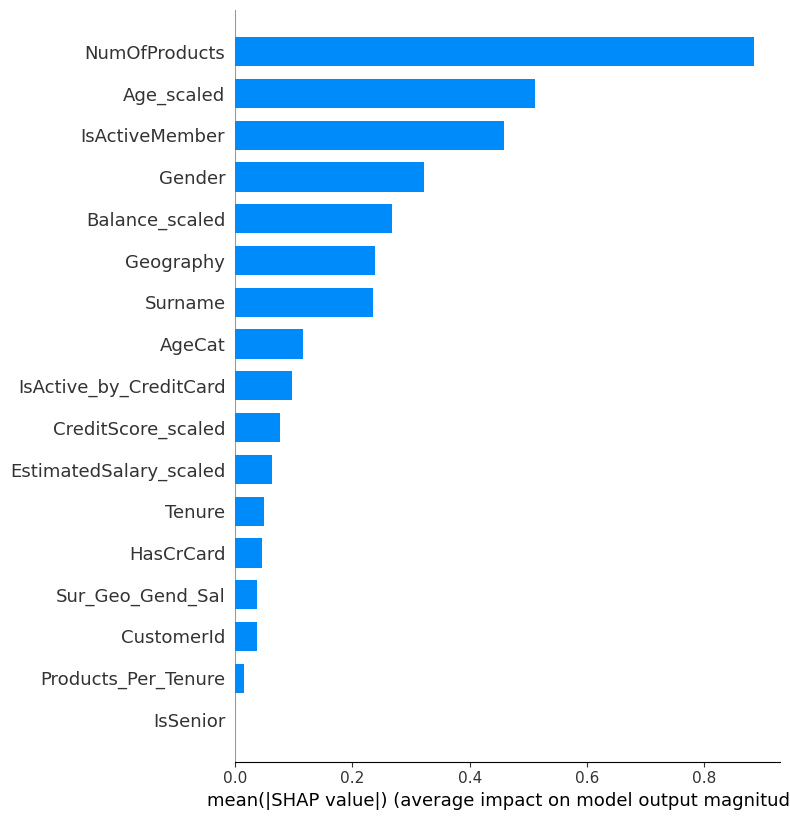

In [11]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Prediction, Submission and Override
Credit : https://www.kaggle.com/competitions/playground-series-s4e1/discussion/469859

In [12]:
y_pred = test_preds.mean(axis=0)
df_orig=pd.read_csv("data\Churn_Modelling.csv")
join_cols=list(df_orig.columns.drop(['RowNumber','Exited']))
df_orig.rename(columns={'Exited':'Exited_Orig'},inplace=True)
df_orig['Exited_Orig']=df_orig['Exited_Orig'].map({0:1,1:0})
df_test_ov=df_test_ov.merge(df_orig,on=join_cols,how='left')[['id','Exited_Orig']].fillna(-1)
####
df_sub = df_test_ov[['id','Exited_Orig']]

if USE_DATA_LEAK=='Y':
    df_sub['Exited'] = np.where(df_sub.Exited_Orig==-1,y_pred,df_sub.Exited_Orig)
else:
    df_sub['Exited'] = y_pred
    
df_sub.drop('Exited_Orig',axis=1,inplace=True)
df_sub.head()

,id,Exited
0,165034,0.013261
1,165035,0.814239
2,165036,0.013728
3,165037,0.200730
4,165038,0.393234


In [13]:
df_sub.to_csv("submission.csv",index=False)

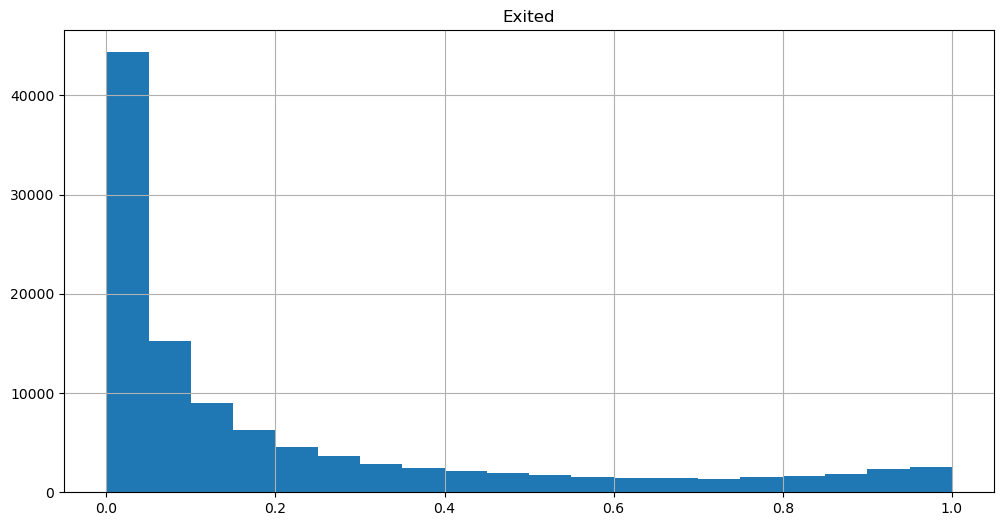

In [14]:
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()